In [ ]:
import pandas as pd
import os
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

In [46]:
# import libraries
os.chdir('/Users/ryan-saloma/Python Projects/string manipulation')

# load data
df = pd.read_csv('movies.csv')

# inspect data
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN


A few ideas:
- Remove alphabetic and parantheses from YEAR column (str.strip, Series.replace)
- Split YEAR column to create start_year and end_year for TV shows (str.split)
- Impute missing values with default missing value indicator in pandas (pd.NA)
- Split STARS column into new director, actors columns
- Split genres into separate columns (Q: how to determine what are the unique values?)
- Change default value for 'ONE-LINE' to None (currently 'Add a Plot')
- For shows that are still on (YEAR = 2020-), fill end_year with appropriate value (present?)

String manipulation methods to practice:
split()
strip()
lstrip(): removing spaces and chars from the beginning of a string in Python
rstrip(): removing spaces and chars from the end of a string in Python
strip(): removing spaces and chars from the beginning and end of a string in Python
String Lowercase in Python
String Uppercase in Python
String Title Case in Python
String Swap Case in Python
Checking if a string is empty in Python
rjust(): right-justified string in Python
ljust(): left-justified string in Python
isalnum(): checking alphanumeric only in a string in Python
isprintable(): checking printable characters in a string in Python
isspace(): checking white space only in a string in Python
startswith(): checking if a string begins with a certain value in Python
capitalize(): first character only to upper case in a string in Python
isupper(): checking upper case only in a string in Python
endswith(): check if a string ends with a certain value in Python
join(): join items of an iterable into one string in Python
splitlines(): splitting a string at line breaks in Python
islower(): checking lower case only in a string in Python
isnumeric(): checking numerics only in a string in Python
isdigit(): checking digits only in a string in Python
isdecimal(): checking decimals only in a string in Python
isalpha(): checking letters only in a string in Python
istitle(): checking if every word begins with an upper case char in a string in Python
expandtabs(): set the number of spaces for a tab in a string in Python
center(): centered string in Python
zfill(): add zeros to a string in Python
find(): check if a string has a certain substring in Python
Removing a Prefix or a Suffix in a String in Python
Python: lstrip() vs removeprefix() and rstrip() vs removesuffix()
How to reverse a string in Python
Understanding Slicing in Python
String Interpolation with f-strings in Python


In [47]:
# Clean data

# Clean YEAR column

# remove alpha characters and parantheses from year column
# NOTE: strip is a string method but replace is a pandas method
df['YEAR'] = df['YEAR'].str.strip().replace(r'[A-Za-z\(\)]', '', regex=True)

# split year range into start and end year columns
df[['start_year','end_year']] = df['YEAR'].str.split('–',expand=True)

# fill missing start year with pd.NA
df['start_year'] = df['start_year'].replace('', pd.NA)

# fill missing end year with pd.NA
df['end_year'] = df['end_year'].replace('', pd.NA).replace(' ', pd.NA)

# Clean STARS column

# Function to extract director
def extract_director(text):
    if("Director:" in text): 
        director = text.split("Director:")[1].split("|")[0].strip()
        return director.strip()
    else:
        return None

# Function to extract actors
def extract_actors(text):
    if("Stars:" in text): 
        actors_part = text.split("Stars:")[1]
        actors = ", ".join([actor.strip() for actor in actors_part.split(",\n")])
        return actors
    else:
        return None

# Apply the functions to create new columns
df['director'] = df['STARS'].apply(extract_director)
df['actors'] = df['STARS'].apply(extract_actors)

# Drop the original STARS column if no longer needed
df = df.drop(columns=['STARS'])

# Clean GENRE column

# remove leading and trailing whitespaces and convert to lowercase
# remove spaces
df['GENRE'] = df['GENRE'].str.strip().str.lower()
df['GENRE'] = df['GENRE'].str.replace(' ','') 
list_of_genres_by_title = df['GENRE'].str.split(',')

# sort each list in x and handle missing values
sorted_list_of_genres_by_title = list_of_genres_by_title.apply(lambda x: sorted(x, reverse=True) if isinstance(x, list) else x)
new_genre_column = sorted_list_of_genres_by_title.str.join(',')
dummies = new_genre_column.str.get_dummies(sep=',').add_prefix('genre_')

# drop temporary data
del list_of_genres_by_title
del sorted_list_of_genres_by_title
del new_genre_column

# # Concatenate the dummies with the original dataframe
df = pd.concat([df, dummies], axis=1)

# Rename columns
df = df.rename(columns={'MOVIES':'title', 'GENRE': 'genre', 'YEAR':'year_range', \
                        'RunTime':'runtime', 'RATING':'rating', 'VOTES':'votes', 'ONE-LINE':'one-line', \
                        'Gross':'gross', 'actors':'actors'})

# convert votes column
df['votes'] = pd.to_numeric(df['votes'].str.replace(',', ''))

# Save the cleaned data
df.to_csv('cleaned_movies.csv', index=False)


In [8]:
# Perform sentiment analysis on one-line
# TODO: set up to use GPU
# TODO: tune for purposes of this project
sentiment_analysis = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
df['sentiment'] = df['one-line'].apply(lambda x: sentiment_analysis(x)[0]['label']) 

# get dummies for sentiment
dummies = pd.get_dummies(df['sentiment'], prefix='sentiment')
df = pd.concat([df, dummies], axis=1)

# save the data
df.to_csv('cleaned_movies_with_sentiment.csv', index=False)

genre_action  genre_adventure  genre_animation  genre_biography  genre_comedy  genre_crime  genre_documentary  genre_drama  genre_family  genre_fantasy  genre_film-noir  genre_game-show  genre_history  genre_horror  genre_music  genre_musical  genre_mystery  genre_news  genre_reality-tv  genre_romance  genre_sci-fi  genre_short  genre_sport  genre_talk-show  genre_thriller  genre_war  genre_western
0             0                0                0                0             0            0                  0            0             0              0                0                0              0             0            0              0              0           0                 0              0             0            0            0                0               0          0                6.563636
                                                                                                                                                                                        

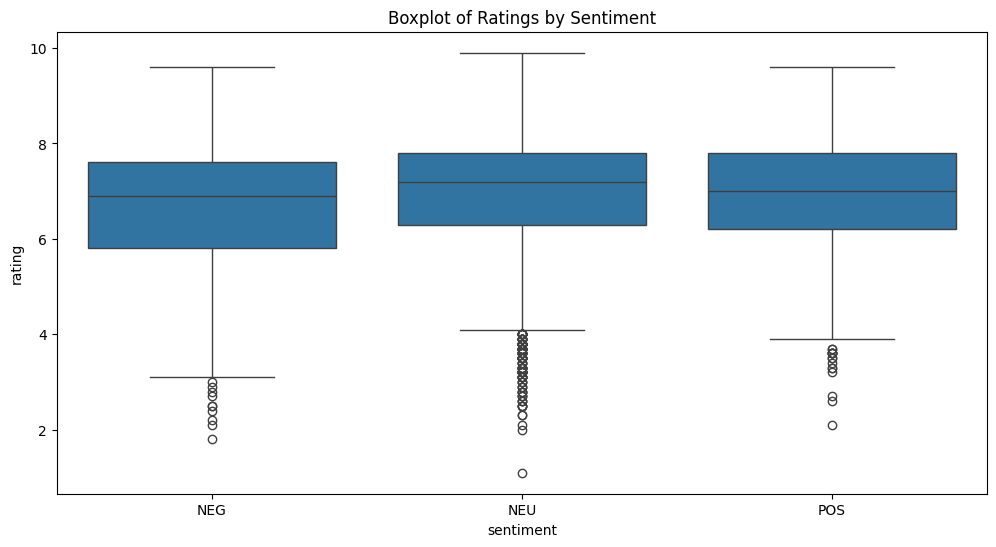

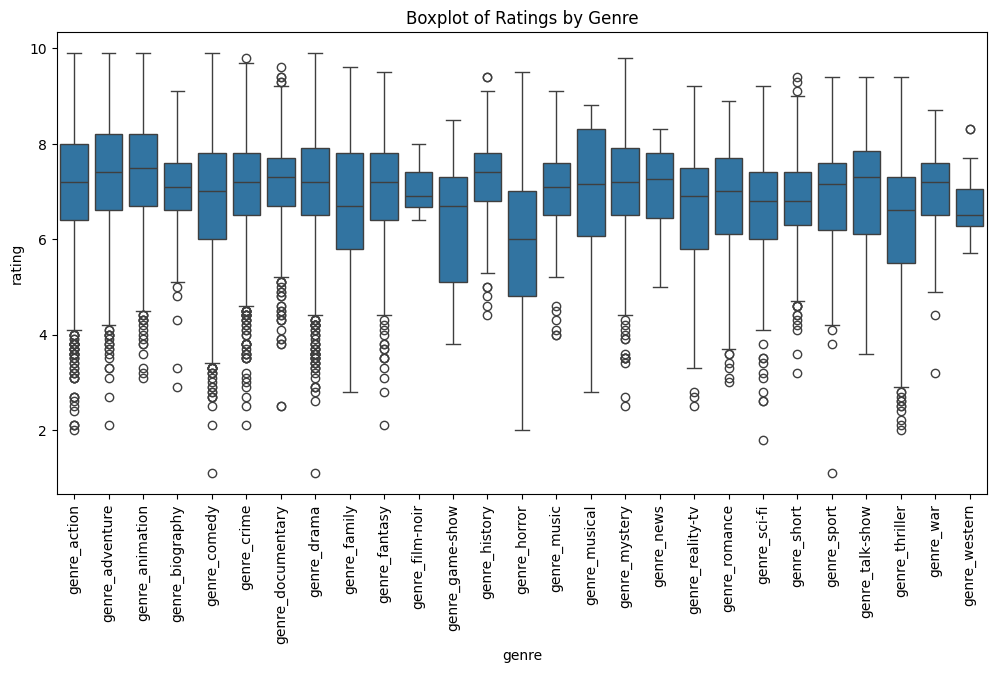

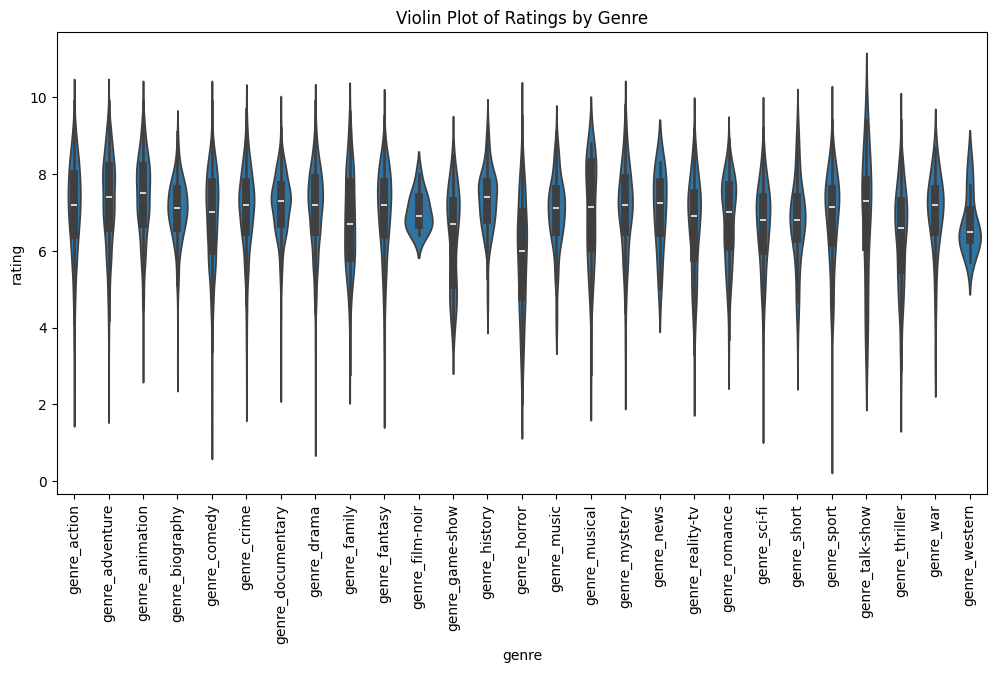

In [6]:
# Analyze relationships

# Load data
df = pd.read_csv('cleaned_movies_with_sentiment.csv')

# explore relationship between sentiment and rating
df.pivot_table(index='sentiment', values='rating', aggfunc=['count', 'mean', 'std', 'max', 'min'])

# visualize the relationship between sentiment and rating
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='rating', data=df)
plt.title('Boxplot of Ratings by Sentiment')

# explore relationship between genre and rating
genre_columns = [col for col in df.columns if col.startswith('genre_')]
mean_ratings = df.groupby(genre_columns)['rating'].mean()
print(mean_ratings)

# Visualize the relationship between genre and rating

# Melt the DataFrame to long format for seaborn
df_melted = df.melt(id_vars=['rating'], value_vars=genre_columns, var_name='genre', value_name='is_genre')
df_melted = df_melted[df_melted['is_genre'] == 1].dropna()

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='rating', data=df_melted)
plt.xticks(rotation=90)
plt.title('Boxplot of Ratings by Genre')
plt.show()

# Violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='genre', y='rating', data=df_melted)
plt.xticks(rotation=90)
plt.title('Violin Plot of Ratings by Genre')
plt.show()


It appears there is no relationship between the sentiment of the description and rating. It does appear, however, that there are differences in ratings by genre, particularly in the spread of ratings and minimum values. For example, while the median rating of horror movies is not drastically different than movies of other genres, the ratings are clearly quite variable, and the worst-rated horror movies appear lower than the worst-rated movies of other genres. 

Follow-up questions: 
- Is there something that the lowest ranked horror movies (or movies in general) share? Can we quantify the amount of overlap between their one-line descriptions?
- Can we control for the number of reviews? What other variables might we want to control for?
- Can a decision tree or random forest reveal any features important to the classification of movie?

              precision    recall  f1-score   support

        high       0.87      0.90      0.88       181
         low       0.00      0.00      0.00         2
      medium       0.62      0.46      0.52        35
   very_high       0.47      0.53      0.50        15

    accuracy                           0.80       233
   macro avg       0.49      0.47      0.48       233
weighted avg       0.80      0.80      0.80       233

Feature ranking:
votes: 0.3409692614342605
runtime: 0.1523263191056655
start_year: 0.10758302181468613
end_year: 0.09653608452734548
genre_family: 0.030893917738139858
genre_action: 0.027751535738598974
genre_drama: 0.022404142594161507
genre_adventure: 0.021867617574288532
genre_comedy: 0.019219955538198916
genre_animation: 0.018434932479794185
genre_crime: 0.016813775984420968
genre_short: 0.014340624251818949
genre_sci-fi: 0.013937090499807346
genre_thriller: 0.013210941787346024
genre_mystery: 0.01244791873349923
sentiment_NEU: 0.009140227919054446
sentim

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33],
 [Text(0, 0, 'votes'),
  Text(1, 0, 'runtime'),
  Text(2, 0, 'start_year'),
  Text(3, 0, 'end_year'),
  Text(4, 0, 'genre_family'),
  Text(5, 0, 'genre_action'),
  Text(6, 0, 'genre_drama'),
  Text(7, 0, 'genre_adventure'),
  Text(8, 0, 'genre_comedy'),
  Text(9, 0, 'genre_animation'),
  Text(10, 0, 'genre_crime'),
  Text(11, 0, 'genre_short'),
  Text(12, 0, 'genre_sci-fi'),
  Text(13, 0, 'genre_thriller'),
  Text(14, 0, 'genre_mystery'),
  Text(15, 0, 'sentiment_NEU'),
  Text(16, 0, 'genre_fantasy'),
  Text(17, 0, 'sentiment_NEG'),
  Text(18, 0, 'sentiment_POS'),
  Text(19, 0, 'genre_talk-show'),
  Text(20, 0, 'genre_romance'),
  Text(21, 0, 'genre_documentary'),
  Text(22, 0, 'genre_reality-tv'),
  Text(23, 0, 'genre_horror'),
  Text(24, 0, 'genre_music'),
  Text(25, 0, 'genre_history'),
  Te

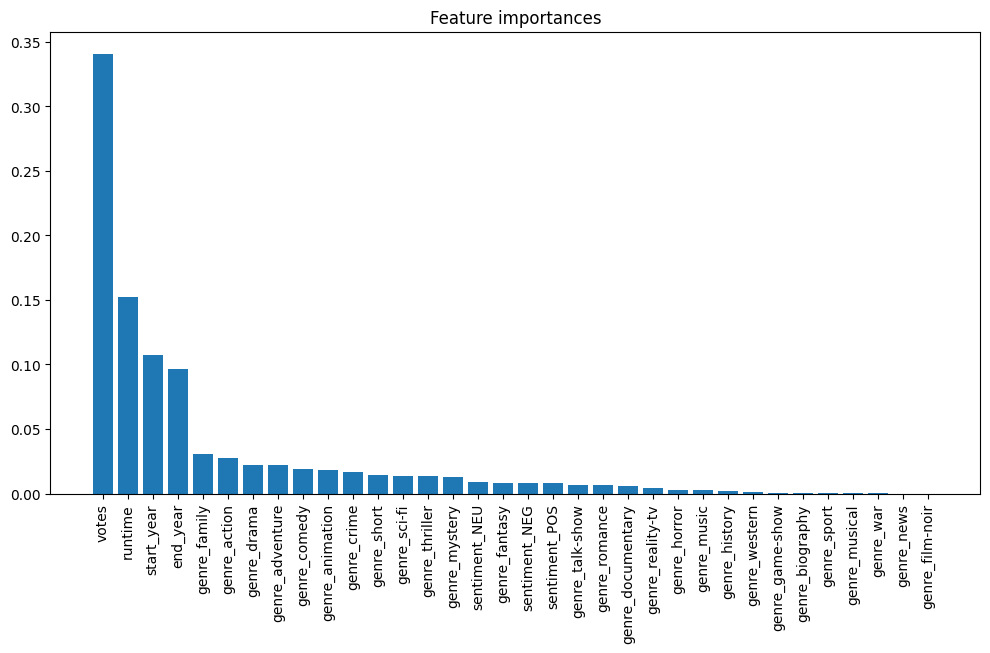

In [9]:
# Create random forest model to predict rating

# first, create bins for rating
bins = [0, 3, 5, 7, 9, 10]
labels = ['very_low', 'low', 'medium', 'high', 'very_high']
df['rating_bin'] = pd.cut(df['rating'], bins=bins, labels=labels)

# second, drop rows with missing values
df = df.dropna(subset=genre_columns + ['rating_bin'])

# drop rows with very_low rating_bin
df = df[df['rating_bin'] != 'very_low']

# third, create a random forest model
model = RandomForestClassifier()

# do some cleanup
# convert votes column to numeric
cols_to_drop = ['title', 'genre', 'year_range', 'rating', 'one-line', 'gross', 'director', 'actors', 'sentiment']
cols_of_interest =[x for x in df.columns if x not in cols_to_drop]
tmp = df.dropna(subset= cols_of_interest + ['rating_bin'])
X = tmp.drop(columns=cols_to_drop + ['rating_bin'])
y = tmp['rating_bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# fourth, identify the most important features
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# print the feature ranking with column names
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{X.columns[indices[f]]}: {importances[indices[f]]}")

# visualize the feature importances and column names
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(X.columns[indices], importances[indices], align="center")
plt.xticks(rotation=90)

There appear to be some relationships between rating and votes, rating and runtime, and rating and year. Next, let's attempt to understand the nature of this relationship.

In [23]:
# create runtime bins
bins = [0, 60, 90, 120, 150, 180, 210, 240, 270, 300]
labels = ['<60', '60-90', '90-120', '120-150', '150-180', '180-210', '210-240', '240-270', '270-300']
df['runtime_bin'] = pd.cut(df['runtime'], bins=bins, labels=labels)

# create a table with mean, median, std of rating by runtime_bin
rating_by_runtime_table = pd.pivot_table(df, index='runtime_bin', values='rating', aggfunc=['count','mean', 'median', 'std'], observed=False)

# create voting bins
bins = [0, 1000, 10000, 100000, 1000000, 10000000]
labels = ['<1k', '1k-10k', '10k-100k', '100k-1M', '1M-10M']
df['votes_bin'] = pd.cut(df['votes'], bins=bins, labels=labels)

# create a table with mean, median, std of rating by votes_bin
rating_by_votes_table = pd.pivot_table(df, index='votes_bin', values='rating', aggfunc=['count','mean', 'median', 'std'], observed=False)

# output the tables
rating_by_runtime_table.to_excel('rating_by_runtime_table.xlsx')
rating_by_votes_table.to_excel('rating_by_votes_table.xlsx')

,count,mean,median,std
,rating,rating,rating,rating
votes_bin,,,,
<1k,4412,6.924456,7.10,1.170981
1k-10k,2477,6.891603,7.00,1.235489
10k-100k,955,6.970890,7.10,1.150094
100k-1M,291,7.493471,7.60,0.900034
1M-10M,6,8.733333,8.75,0.432049


Unsurprisingly, it looks like movies that have a lot of ratings tend to be higher rated. 